In [1]:
import env
import pandas as pd
pd.set_option('display.max_columns', 50)

import os

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBacked.figure_format = 'retina'
import re

# Acquire

1. Read tables
2. Join tables

In [3]:
def acquire_store_data():

    filename = 'data/store_data_raw'
    
    # if file doesn't exist, acquire and cache
    if not os.path.isfile(filename):
    
        db = 'superstore_db'
        
        categories_query = "SELECT * FROM categories;"
        customers_query  = "SELECT * FROM customers;"
        orders_query     = "SELECT * FROM orders;"
        products_query   = "SELECT * FROM products;"
        regions_query    = "SELECT * FROM regions;"

        
        categories = pd.read_sql(categories_query, 
                                 f'mysql+pymysql://{env.user}:{env.pwd}@{env.host}/{db}')
        customers  = pd.read_sql(customers_query, 
                                 f'mysql+pymysql://{env.user}:{env.pwd}@{env.host}/{db}')
        orders     = pd.read_sql(orders_query, 
                                 f'mysql+pymysql://{env.user}:{env.pwd}@{env.host}/{db}')
        products   = pd.read_sql(products_query, 
                                 f'mysql+pymysql://{env.user}:{env.pwd}@{env.host}/{db}')
        regions    = pd.read_sql(regions_query, 
                                 f'mysql+pymysql://{env.user}:{env.pwd}@{env.host}/{db}')
        
        # join tables
        df = orders.merge(customers, on='Customer ID', how='left')
        df = df.merge(categories, on='Category ID', how='left')
        df = df.merge(regions, on='Region ID', how='left')
        df = df.merge(products, on='Product ID', how='left')

        df.to_csv(filename, index=False)
        
        return df
    
    return pd.read_csv(filename)

In [4]:
df = acquire_store_data()

In [5]:
df.head(3)

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Country,City,State,Postal Code,Product ID,Sales,Quantity,Discount,Profit,Category ID,Region ID,Customer Name,Category,Sub-Category,Region Name,Product Name
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,42420.0,FUR-BO-10001798,261.96,2.0,0.0,41.9136,1,1,Claire Gute,Furniture,Bookcases,South,Bush Somerset Collection Bookcase
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,42420.0,FUR-CH-10000454,731.94,3.0,0.0,219.5820,2,1,Claire Gute,Furniture,Chairs,South,"Hon Deluxe Fabric Upholstered Stacking Chairs,..."
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Corporate,United States,Los Angeles,California,90036.0,OFF-LA-10000240,14.62,2.0,0.0,6.8714,3,2,Darrin Van Huff,Office Supplies,Labels,West,Self-Adhesive Address Labels for Typewriters b...


# Prepare

1. rename columns
1. check for missing values
    1. check for empty string values
1. drop duplicate columns (foreign keys)
1. check for duplicate rows
1. ensure correct data types
1. univariate analysis
    1. view value counts
    1. note outliers and handle appropriately
    1. view distributions of numeric data
1. engineer features that may be useful

1. Rename columns

In [6]:
df.columns = [re.sub(r'[^a-zA-Z]', '_', col.lower()) for col in df.columns]
df.columns

Index(['order_id', 'order_date', 'ship_date', 'ship_mode', 'customer_id',
       'segment', 'country', 'city', 'state', 'postal_code', 'product_id',
       'sales', 'quantity', 'discount', 'profit', 'category_id', 'region_id',
       'customer_name', 'category', 'sub_category', 'region_name',
       'product_name'],
      dtype='object')

2. check missing values

In [7]:
df.isna().sum()

order_id         0
order_date       0
ship_date        0
ship_mode        0
customer_id      0
segment          0
country          0
city             0
state            0
postal_code      0
product_id       0
sales            0
quantity         0
discount         0
profit           0
category_id      0
region_id        0
customer_name    0
category         0
sub_category     0
region_name      0
product_name     0
dtype: int64

Look for empty string values

In [8]:
def identify_cols_with_white_space(df):
    '''
    Takes in a DataFrame
    Prints columns with any values that are whitespace
    Returns columns in a list
    '''
    
    cols_w_white_space = []
    
    for col in df.columns:
        # check string/object columns
        if df[col].dtype == 'O':
            # check for any values in the column that are empty or whitespace
            is_whitespace = df[col].str.isspace()
            has_whitespace = is_whitespace.any()
            if has_whitespace:
                print(f'{col} has whitespace')
                cols_w_white_space.append(col)
    return cols_w_white_space

identify_cols_with_white_space(df)

[]

3. drop foreign key columns

In [9]:
df = df.drop(columns=['customer_id','product_id',
                      'category_id', 'region_id'])

4. drop duplicate rows
- there are duplicate orders, but that's fine. I'm am analyzing each item purchased

In [10]:
df.duplicated().sum()

0

In [11]:
df['order_id'].duplicated().sum()

893

5. check data types

In [12]:
df.dtypes

order_id          object
order_date        object
ship_date         object
ship_mode         object
segment           object
country           object
city              object
state             object
postal_code      float64
sales            float64
quantity         float64
discount         float64
profit           float64
customer_name     object
category          object
sub_category      object
region_name       object
product_name      object
dtype: object

In [13]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['ship_date'] = pd.to_datetime(df['ship_date'])
df['postal_code'] = df['postal_code'].astype(int)
df['quantity'] = df['quantity'].astype(int)

6. univariate analysis

    6a. view value counts

Notes:
- `order_id`s: start with US or CA, 2014-2017
- only `country` is US so we can drop this column
- majority of orders are in the Office Supplies `category`
- should bin 0-10, 15-20, 30-50, >50

In [14]:
for col in df.columns:
    display(df[col].value_counts())

US-2016-108504    11
CA-2015-131338    10
CA-2017-117457     9
US-2016-110156     8
US-2017-118087     8
                  ..
CA-2016-152632     1
CA-2016-167584     1
CA-2014-134677     1
CA-2016-161781     1
CA-2017-150707     1
Name: order_id, Length: 841, dtype: int64

2015-09-26    14
2016-10-28    14
2017-12-08    13
2016-06-20    13
2016-11-24    13
              ..
2014-03-10     1
2014-04-21     1
2015-10-22     1
2015-08-22     1
2015-02-08     1
Name: order_date, Length: 570, dtype: int64

2016-11-24    17
2016-11-26    13
2017-11-21    11
2017-12-12    11
2016-02-05    11
              ..
2014-10-10     1
2015-05-14     1
2016-07-19     1
2016-07-07     1
2017-09-22     1
Name: ship_date, Length: 608, dtype: int64

Standard Class    980
Second Class      354
First Class       326
Same Day           74
Name: ship_mode, dtype: int64

Consumer       954
Corporate      478
Home Office    302
Name: segment, dtype: int64

United States    1734
Name: country, dtype: int64

New York City     192
Los Angeles       124
Philadelphia      123
San Francisco      96
Seattle            62
                 ... 
Jefferson City      1
Murrieta            1
Boca Raton          1
Murfreesboro        1
Bristol             1
Name: city, Length: 247, dtype: int64

California              326
New York                240
Texas                   167
Pennsylvania            137
Ohio                     90
Washington               82
Illinois                 77
Florida                  61
Michigan                 54
Arizona                  52
Colorado                 46
North Carolina           44
Virginia                 35
Georgia                  32
Minnesota                32
New Jersey               29
Kentucky                 22
Indiana                  22
Massachusetts            16
Tennessee                13
Alabama                  13
Wisconsin                13
Delaware                 12
Oregon                   12
Utah                     12
Iowa                     11
Louisiana                10
Connecticut               9
Arkansas                  8
Mississippi               7
District of Columbia      7
Maryland                  6
Nevada                    5
Rhode Island              5
Missouri                  5
Nebraska            

10024    55
10035    53
10009    48
94110    42
10011    36
         ..
94509     1
92646     1
73071     1
94521     1
84041     1
Name: postal_code, Length: 306, dtype: int64

12.960     9
15.552     9
19.440     6
10.368     6
32.400     6
          ..
470.376    1
51.520     1
8.792      1
69.712     1
154.240    1
Name: sales, Length: 1504, dtype: int64

3     432
2     425
4     206
5     180
1     155
7     115
6      98
8      50
9      40
14      9
10      8
13      7
12      6
11      3
Name: quantity, dtype: int64

0.00    810
0.20    656
0.70     82
0.80     46
0.40     41
0.30     31
0.60     19
0.50     18
0.10     14
0.15      8
0.45      5
0.32      4
Name: discount, dtype: int64

0.0000     14
6.2208      8
5.4432      8
15.5520     6
3.6288      6
           ..
2.1900      1
9.7608      1
78.7528     1
4.0095      1
17.3520     1
Name: profit, Length: 1589, dtype: int64

Zuschuss Carroll    16
Naresj Patel        15
Joel Eaton          15
Becky Martin        13
Ross Baird          13
                    ..
Rose O'Brian         1
Sonia Sunley         1
Larry Hughes         1
Xylona Preis         1
Filia McAdams        1
Name: customer_name, Length: 525, dtype: int64

Office Supplies    1055
Furniture           360
Technology          319
Name: category, dtype: int64

Binders        263
Paper          224
Furnishings    168
Storage        162
Phones         157
Art            149
Accessories    131
Chairs          95
Appliances      71
Labels          67
Tables          62
Envelopes       48
Fasteners       43
Bookcases       35
Supplies        28
Machines        21
Copiers         10
Name: sub_category, dtype: int64

East       556
West       541
Central    389
South      248
Name: region_name, dtype: int64

Easy-staple paper                                                 10
Staples                                                            9
Xerox 1881                                                         7
Staple envelope                                                    6
DAX Value U-Channel Document Frames, Easel Back                    6
                                                                  ..
Jabra SPEAK 410                                                    1
Verbatim 25 GB 6x Blu-ray Single Layer Recordable Disc, 1/Pack     1
Office Star - Mesh Screen back chair with Vinyl seat               1
Premium Transparent Presentation Covers by GBC                     1
White GlueTop Scratch Pads                                         1
Name: product_name, Length: 1091, dtype: int64

View unique order IDs
- First two letters (country)
- Middle 4 numbers (year)

In [15]:
df['order_id'].str[:2].unique()

array(['CA', 'US'], dtype=object)

In [16]:
df['order_id'].str[3:7].unique()

array(['2016', '2015', '2014', '2017'], dtype=object)

6b. note and handle outliers appropriately
- sales above 500
- quantities above 9
- discounts > 50%
- profits not between -25 and 50

**Note: for now outliers will be kept**

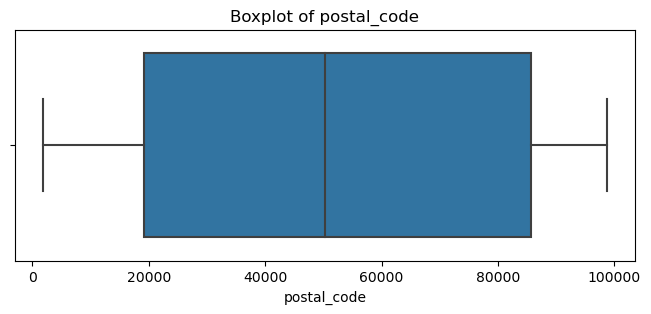

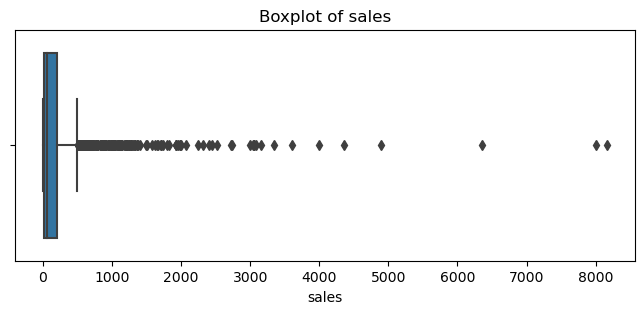

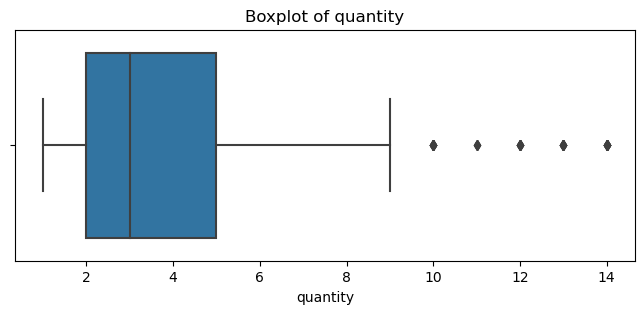

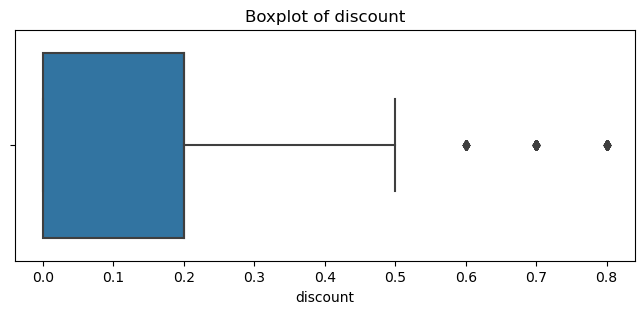

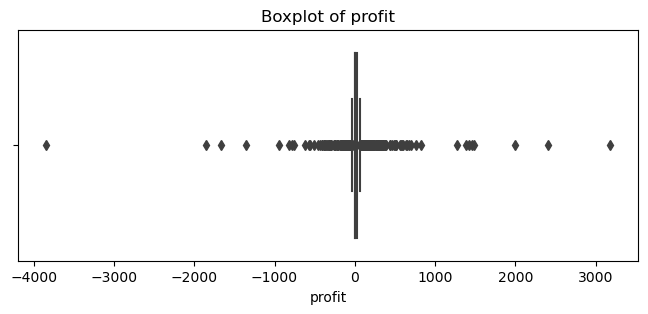

In [17]:
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        plt.figure(figsize=(8, 3))
        sns.boxplot(data=df, x=col)
        plt.title(f'Boxplot of {col}')
        plt.show()

6c. view distributions of numeric data

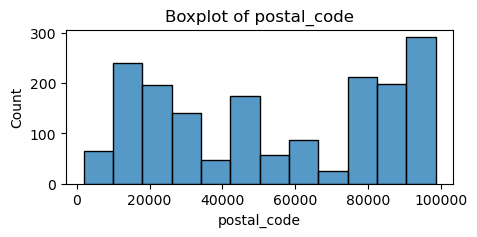

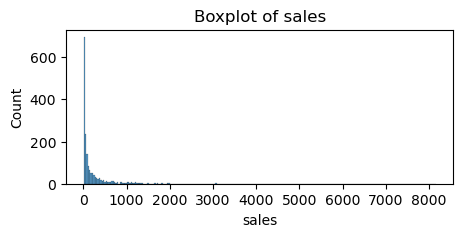

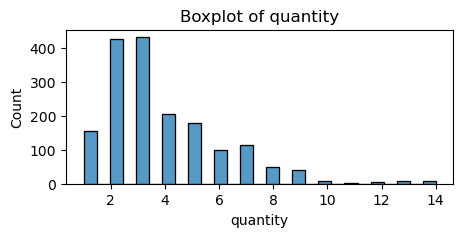

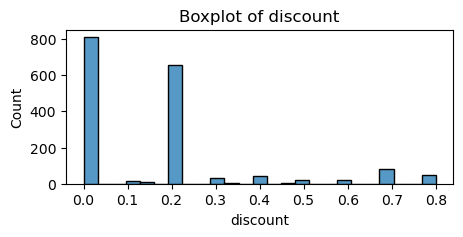

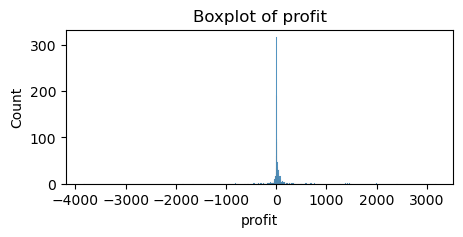

In [18]:
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        plt.figure(figsize=(5, 2))
        sns.histplot(data=df, x=col)
        plt.title(f'Boxplot of {col}')
        plt.show()

Feature Engineering
- Add order month / year
- Add `cost` column which is `sales` - `profit`

In [19]:
df['order_month'] = df['order_date'].dt.month
df['order_year'] = df['order_date'].dt.year

In [20]:
df['cost'] = df['sales'] - df['profit']

Combine into a function

In [21]:
def prep_store_data(df):
    """
    Preprocesses and cleans the store data DataFrame.
    
    Args:
    df (DataFrame): Input DataFrame containing raw store data.
    
    Returns:
    DataFrame: Prepared DataFrame with cleaned columns and new features.
    """
    # Clean column names by converting to lowercase and replacing white spaces with underscores
    df.columns = [re.sub(r'[^a-zA-Z]', '_', col.lower()) for col in df.columns]

    # Drop foreign key columns
    df = df.drop(columns=['customer_id', 'product_id', 'category_id', 'region_id'])
    
    # Convert date columns to datetime
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['ship_date'] = pd.to_datetime(df['ship_date'])
    
    # Convert postal_code and quantity columns to integers
    df['postal_code'] = df['postal_code'].astype(int)
    df['quantity'] = df['quantity'].astype(int)
    
    # Extract order month and year from order_date
    df['order_month'] = df['order_date'].dt.month
    df['order_year'] = df['order_date'].dt.year
    
    # Calculate cost column
    df['cost'] = df['sales'] - df['profit']
    
    return df